In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import spectrogram
from scipy.interpolate import interp1d
from scipy.signal import gaussian
from random import randint


In [52]:
def get_spectrogram(data, winlen=16):
    f,t, Sp = spectrogram(data, 40, nperseg=winlen)
    pSp = [np.mean(s) for s in Sp.T]

    f = interp1d(t, pSp, kind='linear')
    x = np.linspace(t[0],t[-1],6000)
    y = f(x)
    return y

def calculate_coda(data, p_, s_, p_next):
    win_mavg = (p_next-p_)//5
    sp = np.array([get_spectrogram(x) for x in data ])
    mask = np.zeros(sp.shape)
    mask[:, p_:p_next] = 1
    sp = sp*mask

    en_smooth = np.zeros_like(data[:, p_:p_next])
    for i in range(len(data)):
        sp_ = sp[i , p_:p_next]
        cum_en = np.array([sp_[s:].sum() for s in range(len(sp_))])
        en_smooth[i] = np.convolve(cum_en, np.ones(win_mavg)/win_mavg, mode='same')

    std_mean = en_smooth.mean(axis=0)
    diff = np.diff(std_mean, 2)
    diff[diff < 0] = 0

    std_mean_norm = (std_mean-std_mean.min())/(std_mean.max()-std_mean.min())
    coda_ = np.argmax(diff) + 2 + p_
    snr = 0
    
    while (coda_<p_next and snr<2):
        if coda_>s_:
            sc = data[:, s_:coda_].mean(axis=0)
            nc = data[:, coda_:coda_+(coda_-s_)].mean(axis=0)
            snr = sc.std()/nc.std()
            # print(snr)
        coda_ += 40
        if coda_>p_next-1: coda_=p_next

    return coda_, std_mean_norm


1099


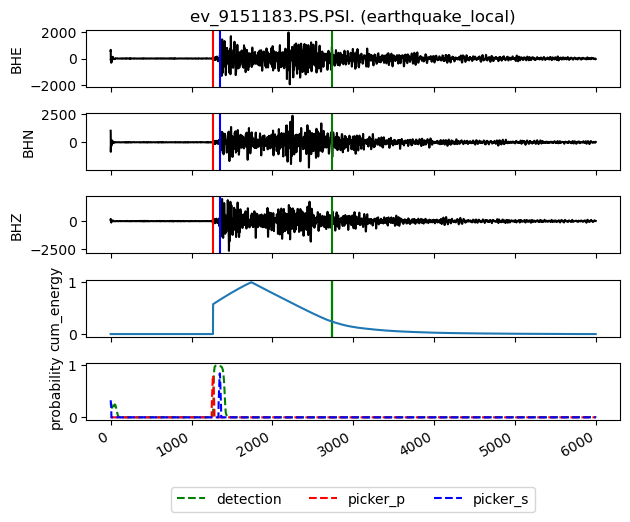

In [59]:
year, endyear = 2010, 2022
maxdepth, maxrad = 20, 3

metadata = pd.read_csv(f'../data/indonesia/{2010}.{endyear}.{maxdepth}.{maxrad}.metadata_indo.csv')
h5_path = f'../data/indonesia/{year}.{endyear}.{maxdepth}.{maxrad}.chunk_indo.hdf5'

i = randint(0,len(metadata)-1)
# i = 155
print(i)
thres = .2
for i, row in list(metadata.iterrows())[i:i+1]:
    with h5py.File(h5_path, 'r') as r:
        dt = r.get(row.id)
        data = dt['data']
        data_ = np.array(data)
        output = dt['output']
        
        fig, ax = plt.subplots(5)
        peaks_p,_ = find_peaks(output[0], height=thres)
        peaks_s,_ = find_peaks(output[1], height=thres)
        # p_, s_, coda_ = data.attrs['p_'], data.attrs['s_'], data.attrs['coda_']
        pp = output[0]
        sp = output[1]
        pp[pp<thres] = 0
        sp[sp<thres] = 0

        ax[0].set_title(f'{row.id} ({row.source_type})')
        mov_std = np.zeros_like(data_[0])
        for i, (tr, comp) in enumerate(zip(data, row.component.split(','))):
            lines = ax[i].plot(tr, 'k')
            num_peak = min(len(peaks_p), len(peaks_s))
            for j in range(num_peak):
                p_ = peaks_p[j]
                if (j>0 and p_<s_): continue
                s_ = peaks_s[j]

                if s_ > p_:
                    p_next = 6000
                    if (j+1 != num_peak and peaks_p[j+1] > s_): 
                        p_next = peaks_p[j+1]

                    coda_, std_ = calculate_coda(data_, p_, s_, p_next)
                    mov_std[p_:p_next] = std_
                    ax[i].axvline(x=p_, color='r')
                    if (coda_>s_): ax[i].axvline(x=s_, color='b')

                    # ax[i].axvline(x=s_+(s_-p_)*1.4, color='c', label='coda_1')
                    if (coda_>s_ and coda_!=p_next): 
                        ax[i].axvline(x=coda_, color='g', label='coda_2')
                        ax[len(data)].axvline(x=coda_, color='g')
            ax[i].set_ylabel(comp)

        ax[len(data)].plot(mov_std)
        ax[len(data)].set_ylabel('cum_energy')
        ax[len(data)+1].plot(output[2], 'g--', label='detection')
        ax[len(data)+1].plot(pp, 'r--', label='picker_p')
        ax[len(data)+1].plot(sp, 'b--', label='picker_s')
        ax[len(data)+1].set_ylabel('probability')
        fig.autofmt_xdate()
        fig.tight_layout()
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -1.05), ncol=3)
        plt.show()

In [27]:
spec = np.array([get_spectrogram(x, 200) for x in data_ ])
# y_mean,std_mean = spec.mean(axis=0)
std_mean = spec[0]

thres = .05
# std_mean[std_mean > thres]=0
diff = np.diff(std_mean, 2)
diff[diff < 0] = 0

for i in range(3):
    x = data_[i]
    y, std = spec[i]

    fig, ax = plt.subplots(3, figsize=(6,4))
    ax[0].plot(x, 'k')
    ax[0].axvline(np.argmax(diff), color='r')

    ax[1].plot(y)
    ax[2].plot(std)
    ax[2].axvline(np.argmax(diff), color='r')
    # ax[2].axhline(np.argmax(thres), color='g')
    
    plt.tight_layout()
    fig.autofmt_xdate()
    plt.show()

ValueError: too many values to unpack (expected 2)

In [ ]:
std_mean[std_mean > .05]=0

In [ ]:
std_mean

array([0.        , 0.        , 0.        , ..., 0.00040958, 0.00040141,
       0.00039348])

In [ ]:
spec.shape

(3, 2, 6000)

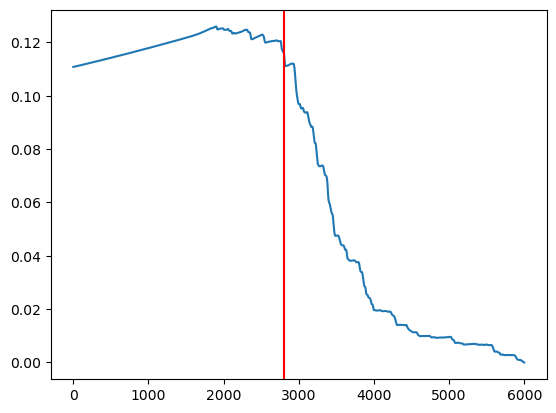

In [ ]:
std_mean = np.array(all_std).mean(axis=0)
diff = np.diff(std_mean, 2)

plt.plot(std_mean)
plt.axvline(np.argmax(diff), color='r')

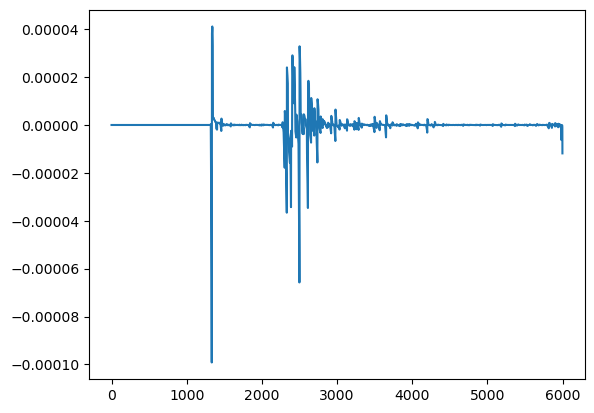

In [ ]:
plt.plot(diff)